# Visualization Experiments 1

The goal of this notebook is to experiment with ways to display the correlation between air temperature and corona cfr

In [1]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("pdf", "svg")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime

In [2]:
data = pd.read_csv("../dat/SimpleCombinedData.csv", parse_dates=["date"])
data.head()

,date,cases,deaths,cases_smoothed,deaths_smoothed,cfr,air temperature
0,2020-01-02,1.0,0.0,0.142857,0.0,0.0,2.519630
1,2020-01-03,0.0,0.0,0.142857,0.0,0.0,2.491579
2,2020-01-04,0.0,0.0,0.142857,0.0,0.0,2.989614
3,2020-01-05,0.0,0.0,0.142857,0.0,0.0,3.619053
4,2020-01-06,0.0,0.0,0.000000,0.0,0.0,3.735754


In [3]:
data.describe()

,cases,deaths,cases_smoothed,deaths_smoothed,cfr,air temperature
count,766.000000,766.000000,766.000000,766.000000,766.000000,766.000000
mean,14389.804178,154.983029,14234.481910,154.978366,0.014988,10.765391
std,27825.896107,225.538655,25245.988139,212.862531,0.015839,7.033025
min,0.000000,0.000000,0.000000,0.000000,0.000000,-7.070667
25%,909.250000,7.000000,962.928571,6.035714,0.005177,4.867907
50%,5258.500000,57.000000,7252.714286,59.928571,0.008655,10.180673
75%,15736.750000,216.500000,17418.785714,225.678571,0.017892,17.417624
max,229055.000000,1284.000000,172263.142857,985.000000,0.074241,27.094450


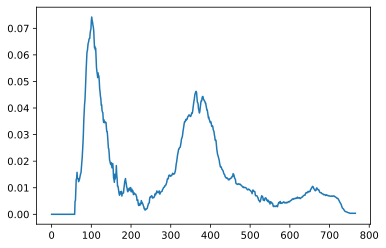

In [4]:
plt.plot(data.cfr)
plt.show()

## The obvious plot

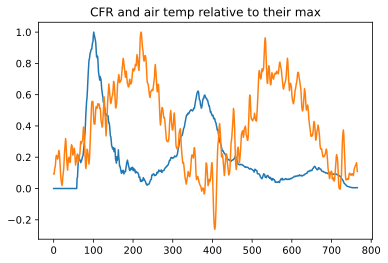

In [5]:
plt.plot(data.cfr / data.cfr.max())
plt.plot(data["air temperature"] / data["air temperature"].max())
plt.title("CFR and air temp relative to their max")
plt.show()

## Scatter plot

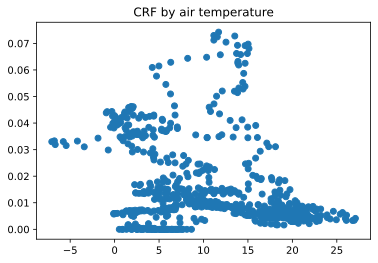

In [6]:
plt.scatter(data["air temperature"], data.cfr)
plt.title("CRF by air temperature")
plt.show()

One can see, that there is no correlation yet, which makes sense, since CFR seems to also generally decrease over time (see exp001). So we also have to include time:

## Heatmap

In [7]:
time = np.unique(data.date.apply(lambda x: f"{x.year}-{x.month:02d}"))
temp = np.arange(
    data["air temperature"].round().min(),
    data["air temperature"].round().max() + 1
)[::-1]

print(time.shape, temp.shape)

(26,) (35,)


In [8]:
print(time[:10])

['2020-01' '2020-02' '2020-03' '2020-04' '2020-05' '2020-06' '2020-07'
 '2020-08' '2020-09' '2020-10']


In [9]:
print(temp)

[27. 26. 25. 24. 23. 22. 21. 20. 19. 18. 17. 16. 15. 14. 13. 12. 11. 10.
  9.  8.  7.  6.  5.  4.  3.  2.  1.  0. -1. -2. -3. -4. -5. -6. -7.]


In [10]:
heatmap = [[ [] for _ in time] for _ in temp]
heatmap_alpha = [[ [] for _ in time] for _ in temp]

for t, at, cfr in zip(data.date, data["air temperature"], data.cfr):
    
    date = f"{t.year}-{t.month:02d}"
    j = np.argwhere(time == date)[0,0]
    
    air_temp = np.round(at)
    i = np.argwhere(temp == air_temp)[0,0]
    
    heatmap[i][j].append(cfr)
    
for i in range(len(heatmap)):
    for j in range(len(heatmap[0])):
        if len(heatmap[i][j]) == 0:
            heatmap[i][j] = 0
            heatmap_alpha[i][j] = 0
        else:
            heatmap[i][j] = np.array(heatmap[i][j]).mean()
            heatmap_alpha[i][j] = 1

heatmap = np.array(heatmap)
heatmap_alpha = np.array(heatmap_alpha, dtype=np.float64)

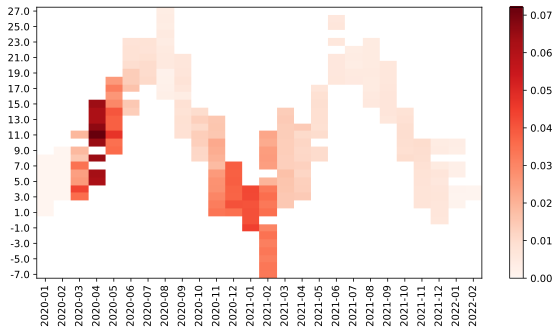

In [11]:
plt.figure(figsize=(10,5))
plt.imshow(heatmap, aspect="auto", cmap="Reds", alpha=heatmap_alpha)
plt.xticks(np.arange(len(time)), time, rotation=90)
plt.yticks(np.arange(len(temp))[::2], temp[::2])
plt.colorbar()
plt.show()

Lets try some predictions now:

In [12]:
from sklearn.linear_model import LinearRegression

In [13]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [14]:
def features(date, temp):
    return np.stack(
    (
        date,
        #np.exp(-0.01* date),
        #np.exp(-temp / 20),
        temp,
    ), axis=1
)

In [15]:
X = features(data.index, data["air temperature"])
y = data.cfr.to_numpy()

peak_of_first_wave = np.argmax(y) # see exp001

In [16]:
model = LinearRegression()
model.fit(X[peak_of_first_wave:], y[peak_of_first_wave:])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

0.09301166928805345


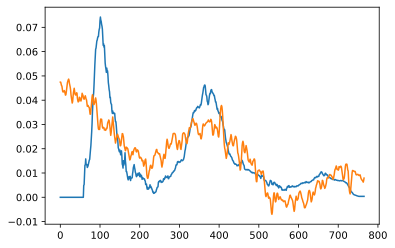

In [17]:
plt.plot(y)
y_pred = model.predict(X)
plt.plot(y_pred)
print(np.square(y[peak_of_first_wave:] - y_pred[peak_of_first_wave:]).mean() * 1000)

predict on all days

In [18]:
days = data.index
days_grid, temp_grid = np.meshgrid(days, temp)

In [19]:
X_pred = features(days_grid.flatten(), temp_grid.flatten())
y_pred = model.predict(X_pred)

put into dataframe, group by month and average prediction

In [20]:
prediction_df = pd.DataFrame(y_pred.reshape(temp.size, days.size).T, index=data.date)
prediction =  prediction_df.groupby(lambda x: f"{x.year}-{x.month:02}").mean().to_numpy().T

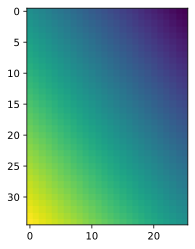

In [21]:
plt.imshow(prediction)

Now we can redo the plot from above, filling the missing values

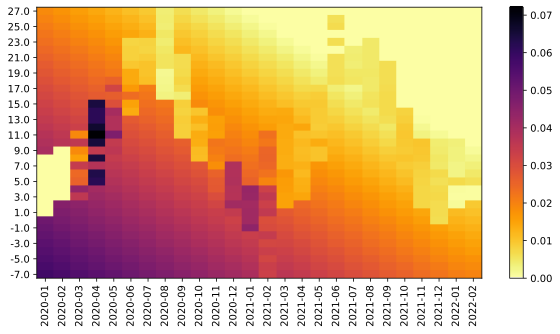

In [22]:
plt.figure(figsize=(10,5))
vmin = heatmap.min()
vmax = heatmap.max()
plt.imshow(prediction, vmin=vmin, vmax=vmax, aspect="auto", cmap="inferno_r")
plt.imshow(heatmap, vmin=vmin, vmax=vmax, aspect="auto", cmap="inferno_r", alpha=heatmap_alpha)
plt.xticks(np.arange(len(time)), time, rotation=90)
plt.yticks(np.arange(len(temp))[::2], temp[::2])
plt.colorbar()
plt.show()

## custom model

This makes the assumption, that the CFR is decreasing exponentially (e.g. due to medical advances) and that temperature has a multiplicative effect given by a sigmoid (i.e. how likely it is, that people are outside).

In [23]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

the expression $time - peak\_of\_first\_wave$ does not do anything as it can be completely counteracted by $a$, but it makes the values more interpretable, since then the function "starts" at the first wave and not at the beginning of the recordings, which would be arbitrary.

In [24]:
def f(X, params):
    time = X[:, 0]
    temp = X[:, 1]
    
    a = params[0]
    b = params[1]
    c = params[2]
    d = params[3]
    
    return a * np.exp(b * (time - peak_of_first_wave)) * sigmoid(c * (temp + d))
guess = [0.15, -0.004,  -0.2, -10]

In [25]:
def f_to_latex(params):
    a = f"{params[0]:0.4f}"
    b = f"{params[1]:0.2f}"
    c = f"{params[2]:0.2f}"
    d = f"{params[3]:0.2f}"
    
    return f"{a} \\cdot e^{{ \\frac{{{b}}}{{d}} \\cdot (t - {peak_of_first_wave}d) }} \\cdot  \\sigma \\left(\\frac{{{c}}}{{^\\circ C}} \cdot (\\theta {'+' if float(d) >= 0 else ''} {d}^\\circ C) \\right) \\cdot \\frac{{deaths}}{{cases}}"

In [26]:
print(f_to_latex(guess))

0.1500 \cdot e^{ \frac{-0.00}{d} \cdot (t - 101d) } \cdot  \sigma \left(\frac{-0.20}{^\circ C} \cdot (\theta  -10.00^\circ C) \right) \cdot \frac{deaths}{cases}


$-0.0040 \cdot e^{ \frac{-60.00}{d} \cdot (t - 101d) } \cdot  \sigma \left(\frac{-0.20}{^\circ C} \cdot (\theta  -10.00^\circ C) \right) \cdot \frac{deaths}{cases}
$

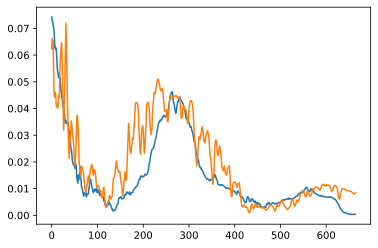

In [27]:
plt.plot(y[peak_of_first_wave:])
y_pred = f(X[peak_of_first_wave:], guess)
#plt.plot(sigmoid((X[peak_of_first_wave:, 1] - 25) * -0.02) -0.5)
plt.plot(y_pred)

In [28]:
from scipy.optimize import minimize

In [29]:
res = minimize(
    lambda params: np.square(y[peak_of_first_wave:] - f(X[peak_of_first_wave:], params)).sum(),
    guess,
    method="Nelder-Mead",
    #method = "BFGS",
    #jac="2-point",
    options={
        "maxiter": 10000
    }
)
params = res.x
res

 final_simplex: (array([[ 0.26358448, -0.00546139, -0.15632469, -3.22685082],
       [ 0.26358308, -0.00546139, -0.15632505, -3.22692594],
       [ 0.26358464, -0.00546139, -0.15632466, -3.22685642],
       [ 0.26358342, -0.00546139, -0.15632506, -3.22691581],
       [ 0.26358477, -0.0054614 , -0.15632505, -3.22687343]]), array([0.03280455, 0.03280455, 0.03280455, 0.03280455, 0.03280455]))
           fun: 0.032804554337551674
       message: 'Optimization terminated successfully.'
          nfev: 255
           nit: 153
        status: 0
       success: True
             x: array([ 0.26358448, -0.00546139, -0.15632469, -3.22685082])

In [30]:
print(np.square(f(X[peak_of_first_wave:], params) - y[peak_of_first_wave:]).sum())

0.032804554337551674


In [31]:
custom_model = lambda x: f(x, params)

(0.0, 0.08)

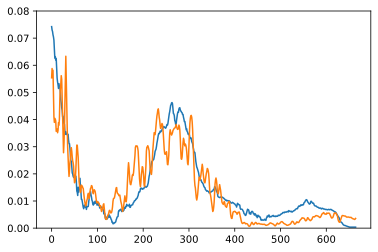

In [32]:
plt.plot(y[peak_of_first_wave:])
y_pred = custom_model(X[peak_of_first_wave:])
plt.plot(y_pred)
plt.ylim([0, 0.08])

In [33]:
y_pred = custom_model(X_pred)

In [34]:
prediction_df = pd.DataFrame(y_pred.reshape(temp.size, days.size).T, index=data.date)
prediction =  prediction_df.groupby(lambda x: f"{x.year}-{x.month:02}").mean().to_numpy().T

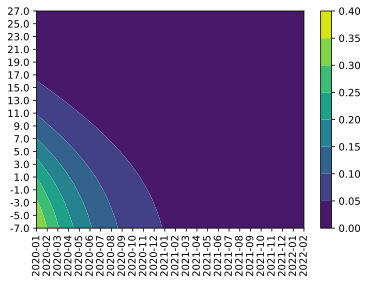

In [35]:
plt.contourf(prediction[::-1])
plt.xticks(np.arange(len(time)), time, rotation=90)
plt.yticks(np.arange(len(temp))[::2], temp[::-2])
plt.colorbar()
plt.show()

In [36]:
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("mycolormap",
    [
        (0 ,"#fdf094"), 
        (0.2, "#f4cc00"),
        (0.3, "#f06c04"),
        (0.5 , "#9e0000"),
        (0.9 , "#470000"), 
        (1   , "black")
    ]
)

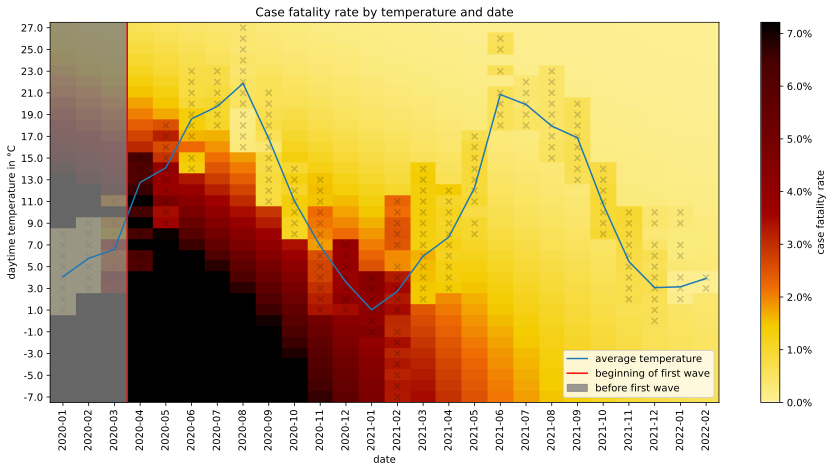

In [37]:
plt.figure(figsize=(15,7))
vmin = heatmap.min()
vmax = heatmap.max()
plt.imshow(prediction, vmin=vmin, vmax=vmax, aspect="auto", cmap=colormap)
hm = plt.imshow(heatmap, vmin=vmin, vmax=vmax, aspect="auto", cmap=colormap, alpha=heatmap_alpha)

a, b = np.where(heatmap_alpha == 1)
plt.scatter(b, a, marker="x", color="black", alpha=0.18)

plt.xticks(np.arange(len(time)), time, rotation=90)
plt.yticks(np.arange(len(temp))[::2], temp[::2])
beginning = 2.5
plt.plot(
    temp.max() - 
    data["air temperature"]
        .groupby(lambda x: f"{data.iloc[x].date.year}-{data.iloc[x].date.month:02d}")
        .mean(),
    label="average temperature"
)
plt.axvline(beginning, color="red", label="beginning of first wave")
plt.fill(
    [-1, -1, beginning, beginning],
    [-0.5, heatmap.shape[0]-0.5, heatmap.shape[0]-0.5, -0.5],
    color="grey",
    alpha = 0.8,
    label="before first wave"
)
plt.colorbar(hm, format=matplotlib.ticker.PercentFormatter(xmax=1), label="case fatality rate", alpha=1)
plt.legend(loc="lower right")
plt.title("Case fatality rate by temperature and date")
plt.xlabel("date")
plt.xlim(-0.5)
plt.ylabel("daytime temperature in °C")
plt.show()

In [38]:
print(f_to_latex(params))

0.2636 \cdot e^{ \frac{-0.01}{d} \cdot (t - 101d) } \cdot  \sigma \left(\frac{-0.16}{^\circ C} \cdot (\theta  -3.23^\circ C) \right) \cdot \frac{deaths}{cases}


$0.2871 \cdot e^{ \frac{-0.01}{d} \cdot (t - 101d) } \cdot  \sigma \left(\frac{-0.15}{^\circ C} \cdot (\theta  -2.05^\circ C) \right) \cdot \frac{deaths}{cases}
$